### Matching air quality and weather data of the city of Madrid by location

In order to later model the air quality data using statistical models based on the data from each zone or station.



![Madrid Air Quality Zones](https://raw.githubusercontent.com/simonsanvil/madrid-air-quality/master/reports/figures/air_quality_zones_map_madrid.jpeg?token=GHSAT0AAAAAABPBMIAUDWIIYMQRDPDUOHHMYPEDLHA)

In [5]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

import pandas as pd
import os, json, unicodedata

from src.data_matching import match_data_by_station, match_data_by_zone
from src.get_data import get_air_quality_df, get_weather_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
weather_df = get_weather_df("../01-data")
aq_df = get_air_quality_df("../01-data")

aq_df = aq_df[aq_df.time.isin(weather_df.time)]
weather_df = weather_df[weather_df.time.isin(aq_df.time)]

In [19]:
# Get the dictionary of dataframes with the matched data by station
aq_stations_dfs = match_data_by_station(aq_df,weather_df)

# Save each as a csv file
aq_station_datasets_names = {}
if not os.path.isdir("../01-data/interim/aq_weather_by_station"):
    os.mkdir("../01-data/interim/aq_weather_by_station")
for estacion,df in aq_stations_dfs.items():
    dataset_name = estacion.lower().replace(" ","_").replace(".","").replace("/","_")
    dataset_name = "aq_weather_"+unicodedata.normalize('NFKD', dataset_name).encode('ASCII', 'ignore').decode("ASCII")
    # Preprocess and resample by 15 days and then save to csv
    df.drop(
        columns=["estacion"]
    ).set_index(
        "time"
    ).resample(
        "1D"
    ).mean().reset_index(
        drop=False
    ).to_csv(
        f"../01-data/interim/aq_weather_by_station/{dataset_name}.csv",
        index=False
    )
    aq_station_datasets_names[estacion] = dataset_name
json.dump(aq_station_datasets_names,open("../references/air_quality_data/aq_station_datasets_names.json","w"))

[Text(0.5, 1.0, 'Arturo Soria - NO2')]

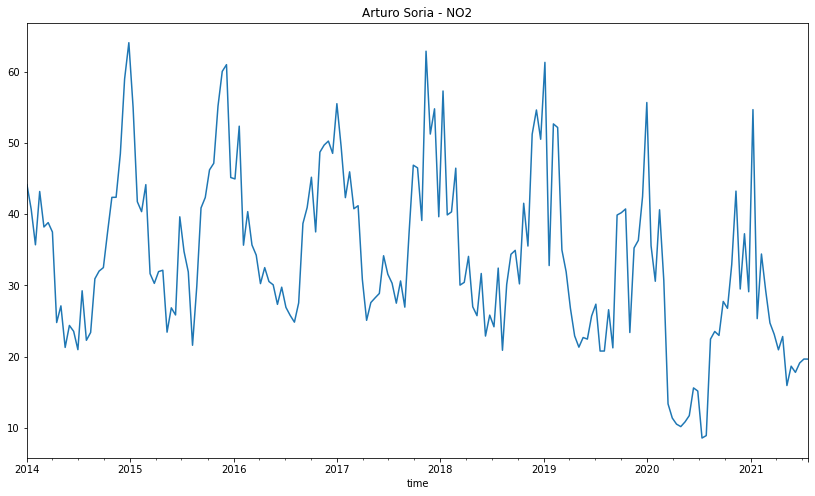

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
aq_stations_dfs["Arturo Soria"]\
     .set_index("time")\
         .resample("15D").mean()['no2_ug_m3'].plot().set(title="Arturo Soria - NO2")

In [7]:
# Get the dictionary of dataframes with the matched data by ZONE
zones_dfs = match_data_by_zone(aq_df,weather_df)

# Save each as a csv file
if not os.path.isdir("../01-data/interim/aq_weather_by_zone"):
    os.mkdir("../01-data/interim/aq_weather_by_zone")

for zone,df in zones_dfs.items():
    dataset_name = f"aq_weather_zone_{zone}"
    # Preprocess and resample by 15 days and then save to csv
    df.drop(
        columns=["estacion"]
    ).set_index(
        "time"
    ).resample(
        "1D"
    ).mean().reset_index(
        drop=False
    ).to_csv(
        f"../01-data/interim/aq_weather_by_zone/{dataset_name}.csv",
        index=False
    )

[Text(0.5, 1.0, 'ZONE 1 - NO2')]

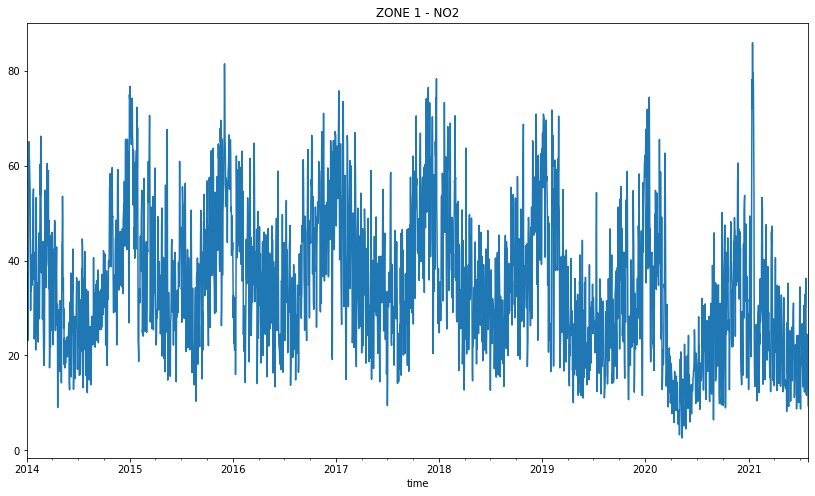

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
zones_dfs[1]\
     .set_index("time")\
         .resample("1D").mean()['no2_ug_m3'].plot().set(title="ZONE 1 - NO2")

------------
Now including traffic

In [17]:
from src.get_data import (
    get_air_quality_df,
    get_weather_df,
    get_traffic_df, 
    get_traffic_locations_df, 
    get_air_locations_df
)
from src.data_matching import match_data
from src.constants import MADRID_AIR_QUALITY_ZONES
import unicodedata


# Get the data
aq_df = get_air_quality_df("../01-data/processed",meteo_normalized = False)
aq_df.columns = aq_df.columns.str.replace("µ","u")
traffic_df = get_traffic_df("../01-data")
traffic_locations_df = get_traffic_locations_df("../01-data")
air_locations_df = get_air_locations_df("../01-data")
weather_df = get_weather_df("../01-data")

# Join and match the data with traffic one
normalized_madrid_df = match_data(
    aq_df=aq_df[aq_df.estacion!="Parque del Retiro"], 
    traffic_df=traffic_df,
    weather_df=weather_df,
    traffic_locations_df=traffic_locations_df,
    air_locations_df=air_locations_df,
    location_by="estacion"
)

In [47]:
# Save each as a csv file
aq_station_datasets_names = {}
if not os.path.isdir("../01-data/interim/aq_weather_traffic_by_station"):
    os.mkdir("../01-data/interim/aq_weather_traffic_by_station")
predictor_vars = [
    "no2_ug_m3","pm10_ug_m3","pm25_ug_m3","o3_ug_m3",
    "u_wind_component_100m", "v_wind_component_100m", 
    "u_wind_component_10m", "v_wind_component_10m", 
    "temperature", "mean_sea_level_pressure", 
    "surface_pressure", "total_precipitation",
    "traffic_intensity","traffic_load"
]
for estacion in normalized_madrid_df.estacion.unique():
    df = normalized_madrid_df[normalized_madrid_df.estacion == estacion]
    dataset_name = estacion.lower().replace(" ","_").replace(".","").replace("/","_")
    dataset_name = "aq_weather_traffic_"+unicodedata.normalize('NFKD', dataset_name).encode('ASCII', 'ignore').decode("ASCII")
    # Preprocess and resample by 15 days and then save to csv
    # remove outliers
    for pollutant in ["pm10_ug_m3","pm25_ug_m3","no2_ug_m3","o3_ug_m3"]:
        if len(df[pollutant].dropna()) < 100:
            continue
        df = df[df[pollutant] < df[pollutant].quantile(0.99)]
    df = df[df.traffic_intensity < df.traffic_intensity.quantile(0.99)]
    df = df[df.traffic_load < df.traffic_load.quantile(0.99)]
    df = df.drop(
        columns=["estacion"]
    )[["time"]+predictor_vars].set_index(
        "time"
    ).resample(
        "1D"
    ).mean().reset_index(
        drop=False
    ).dropna(
        how="all",
        axis=1
    ).dropna(
        how="any",
    )
    aq_station_datasets_names[estacion] = dataset_name
    if len(df) < 100:
        print(f"dataframe for {estacion} has {len(df)} rows only. Skipping..")
        continue
    df.to_csv(
        f"../01-data/interim/aq_weather_traffic_by_station/{dataset_name}.csv",
        index=False
    )
    
# json.dump(aq_station_datasets_names,open("../references/air_quality_data/aq_station_datasets_names.json","w"))

In [28]:

# df[["time","estacion","zone"]+predictor_vars].dropna(how="any")
df

,time,estacion,zone,ben_ug_m3,ch4_mg_m3,co_mg_m3,ebe_ug_m3,nmhc_mg_m3,no2_ug_m3,no_ug_m3,...,u_wind_component_100m,v_wind_component_100m,u_wind_component_10m,v_wind_component_10m,temperature,mean_sea_level_pressure,surface_pressure,total_precipitation,traffic_intensity,traffic_load
1035373,2015-01-02 08:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,74.0,84.0,...,-1.175501,-1.116919,-0.263373,-0.839585,-4.519256,103867.797137,96239.237232,0.000000,21.281087,12.100000
1035375,2015-01-12 11:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,82.0,84.0,...,-2.457115,-1.916761,-1.036507,-1.321353,7.267081,103539.099992,95922.247013,0.000000,23.880479,16.250000
1035376,2015-01-12 12:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,61.0,34.0,...,-1.661106,-0.976006,-1.157912,-0.745563,8.679898,103508.309626,95903.966147,0.000000,23.632641,16.066667
1035377,2015-01-12 13:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,43.0,17.0,...,-1.429275,-0.129802,-1.103450,-0.083689,9.702973,103325.966685,95767.590886,0.000000,25.371198,14.733333
1035378,2015-01-12 14:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,22.0,4.0,...,-1.196029,0.331267,-0.925994,0.294631,10.307210,103182.011731,95658.125059,0.000000,26.684946,18.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087465,2021-07-31 19:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,8.0,1.0,...,1.347742,-5.992111,0.937213,-4.380153,23.840407,101289.122538,94167.461460,0.000027,32.222492,7.583333
1087466,2021-07-31 20:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,9.0,1.0,...,0.580482,-5.781825,0.349516,-4.159243,23.231644,101349.955691,94222.268374,0.000000,30.962069,7.638889
1087467,2021-07-31 21:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,9.0,1.0,...,-0.297440,-5.406995,-0.228747,-3.655221,22.109261,101391.885584,94256.583109,0.000000,29.295195,7.083333
1087468,2021-07-31 22:00:00,Tres Olivos,5,NaN,NaN,NaN,NaN,NaN,11.0,1.0,...,-1.148311,-4.701848,-0.672576,-2.590969,20.307501,101438.795656,94293.991003,0.000000,25.242343,6.472222
